### **Kevin's code**

**Original Convolutional VAE from TF** ([Link](https://www.tensorflow.org/tutorials/generative/cvae))

In [1]:
# to generate gifs
# !pip install -q imageio
# !pip install -q tfp-nightly
# !pip install -q -U tensorflow tensorflow_probability

Import TensorFlow and other necessary libraries

In [32]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, InputLayer, Lambda, Reshape, Dropout, \
                                    Flatten, Dense, Conv2D, Conv2DTranspose  
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
# from keras import objectives
from scipy.stats import norm
import math
import time

Load the MNIST dataset

In [33]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Select a VAE Type, whether Variantional Autoencoder or Convolutional Variantional Autoencoder

In [34]:
vae_type = 'VAE'

Preprocess image

In [68]:
def preprocess_images(images, vae_type_in='VAE'):
    if vae_type_in == 'VAE':
        # Shape it as (n, 784,)
        images = images.astype('float32')/255
        return images.reshape(images.shape[0], -1)
    else:
        # Shape it as (n, 28, 28, 1) 
        images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
        return np.where(images > .5, 1.0, 0.0).astype('float32')

In [69]:
X_train = preprocess_images(X_train, vae_type)
X_test = preprocess_images(X_test, vae_type)

In [70]:
train_dim = X_train.shape[1:]
train_dim

(784,)

In [101]:
# network parameters
batch_size = 100
n_epoch = 100
n_hidden = 1024
z_dim = 2

Use tf.data to batch and shuffle the data

In [39]:
# train_size = 60000
# batch_size = 32
# test_size = 10000

In [40]:
# train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
#                                 .shuffle(train_size)
#                                 .batch(batch_size)
#                  )
# test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
#                                .shuffle(test_size)
#                                .batch(batch_size)
#                 )

In [41]:
# print(train_dataset)
# print(test_dataset)

Define the encoder and decoder networks using keras.Sequential. ([Source](https://keras.io/examples/generative/vae/))

Encoder:

In [80]:
# Initializer imported from Cao code.  May do tuning here.
initializer = keras.initializers.VarianceScaling(scale=0.1,
                                                 mode='fan_in',
                                                 distribution='uniform'
                                                 )

In [81]:
VAEEncoder = keras.Sequential(
    [
        Dense(n_hidden, activation='elu', kernel_initializer=initializer),
        Dropout(0.1),
        Dense(n_hidden//2, activation='elu', kernel_initializer=initializer),
        Dropout(0.1),
        Dense(n_hidden//4, activation='tanh', kernel_initializer=initializer),
        Dropout(0.1)
    ]
)

In [82]:
CVAEEncoder = keras.Sequential(
    [
        Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
        Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
        Flatten(),
        # No activation
        Dense(z_dim + z_dim)
    ]
)

In [83]:
x = Input(shape=train_dim)
x_encoded = VAEEncoder(x) if vae_type == 'VAE' else CVAEEncoder(x)

Retreive the two latent vectors mean and log_std from splitting the final x_encoded.

In [84]:
if vae_type == 'VAE':
    mean = Dense(z_dim, kernel_initializer=initializer)(x_encoded)
    log_stddev = Dense(z_dim, kernel_initializer=initializer)(x_encoded)
else:
    mean, log_stddev = tf.split(x_encoded, z_dim, axis=1)

stddev = 0.000001 + (log_stddev)
# stddev = 0.000001 + K.log(K.exp(log_stddev) + 1)
# std = K.exp(log_stdbdev)

In [85]:
print(mean), print(stddev)

Tensor("dense_30/BiasAdd:0", shape=(None, 2), dtype=float32)
Tensor("AddV2_7:0", shape=(None, 2), dtype=float32)


(None, None)

Sampling function:

In [86]:
# sampling function
##### Fix convention for global variables; remove mean and stddev fixed values.
def sampling(args):
    mean, stddev = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mean + K.exp(stddev) * eps

z = Lambda(sampling, output_shape=(z_dim,))([mean, stddev])
#### Modify this part to sample from coupled gaussians instead of gaussians.

Decoder:

In [87]:
n_hidden, X_train.shape[1]

(1024, 784)

In [88]:
# Initializer imported from Cao code.  May do tuning here.
initializer = keras.initializers.VarianceScaling(scale=0.1,
                                                 mode='fan_in',
                                                 distribution='uniform'
                                                 )

In [89]:
VAEDecoder = keras.Sequential(
    [
        Dense(n_hidden//4, activation='tanh', kernel_initializer=initializer),
        Dropout(0.1),
        Dense(n_hidden//2, activation='elu', kernel_initializer=initializer),
        Dropout(0.1),
        Dense(n_hidden, activation='elu', kernel_initializer=initializer),
        Dropout(0.1),
        Dense(X_train.shape[1], activation='sigmoid', kernel_initializer=initializer)
    ]
)

In [90]:
CVAEDecoder = keras.Sequential(
    [
        Dense(units=7*7*32, activation=tf.nn.relu),
        Reshape(target_shape=(7, 7, 32)),
        Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
        Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
        # No activation
        Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same')
    ]
)

In [91]:
y = VAEDecoder(z) if vae_type == 'VAE' else CVAEDecoder(z)
y = tf.clip_by_value(y, 1e-8, 1 - 1e-8)

In [92]:
'''
# y_decoded = Dense(units=n_hidden//2, activation=tf.nn.relu)(z)
y_decoded = Dense(units=7*7*32, activation=tf.nn.relu)(z)
y_decoded = Reshape(target_shape=(7, 7, 32))(y_decoded)
y_decoded = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(y_decoded)
y_decoded = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(y_decoded)
# No activation
y = Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same')(y_decoded)
'''

"\n# y_decoded = Dense(units=n_hidden//2, activation=tf.nn.relu)(z)\ny_decoded = Dense(units=7*7*32, activation=tf.nn.relu)(z)\ny_decoded = Reshape(target_shape=(7, 7, 32))(y_decoded)\ny_decoded = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(y_decoded)\ny_decoded = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(y_decoded)\n# No activation\ny = Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same')(y_decoded)\n"

In [93]:
# def Decoder(latent_dim=2):

#     return keras.Sequential(
#         [
#             keras.layers.InputLayer(input_shape=(latent_dim,)),
#             keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
#             keras.layers.Reshape(target_shape=(7, 7, 32)),
#             keras.layers.Conv2DTranspose(
#                 filters=64, kernel_size=3, strides=2, padding='same',
#                 activation='relu'),
#             keras.layers.Conv2DTranspose(
#                 filters=32, kernel_size=3, strides=2, padding='same',
#                 activation='relu'),
#             # No activation
#             keras.layers.Conv2DTranspose(
#                 filters=1, kernel_size=3, strides=1, padding='same'),
#         ]
#     )


In [94]:
# Keras approach

'''
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()
'''

'\nlatent_inputs = keras.Input(shape=(latent_dim,))\nx = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)\nx = layers.Reshape((7, 7, 64))(x)\nx = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)\nx = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)\ndecoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)\ndecoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")\ndecoder.summary()\n'

In [96]:
k = 0.225
d = 20
d1 = 1 + d * k + 2 * k

Calculate the marginal_likelihood and the KL_divergence

In [97]:
marginal_likelihood = tf.reduce_sum(x * tf.subtract(tf.pow(y, (2 * k) / (1 + k)), 1) / (2 * k) + (1 - x)
                                    * tf.subtract(tf.pow(1 - y, (2 * k) / (1 + k)), 1) / (k * 2), 1)
KL_d1 = tf.reduce_prod(tf.pow(2 * tf.constant(math.pi), k / (1 + d * k)) * tf.sqrt(d1 / (d1 - 2 * k * tf.square(stddev)))
                       * tf.exp(tf.square(mean) * d1 * k / (1 + d * k) / (d1 - 2 * k * tf.square(stddev))), 1)
KL_d2 = tf.reduce_prod(tf.pow(2 * tf.constant(math.pi) * tf.square(stddev),
                              k / (1 + k * d)) * tf.sqrt(d1 / (1 + d * k)), 1)

KL_divergence = (KL_d1 - KL_d2) / k / 2
ml = marginal_likelihood
marginal_likelihood = tf.reduce_mean(marginal_likelihood)

Create loss function cvae_loss

In [98]:
#reconstruction_loss = objectives.binary_crossentropy(x, y) * x_tr.shape[1]
#kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
ELBO = marginal_likelihood - KL_divergence
vae_loss = -ELBO

#cvae_loss = reconstruction_loss + kl_loss

In [59]:
'''
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """

    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
'''

'\ndef log_normal_pdf(sample, mean, logvar, raxis=1):\n    log2pi = tf.math.log(2. * np.pi)\n    return tf.reduce_sum(\n        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),\n        axis=raxis)\n\ndef compute_loss(model, x):\n    mean, logvar = model.encode(x)\n    z = model.reparameterize(mean, logvar)\n    x_logit = model.decode(z)\n    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)\n    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])\n    logpz = log_normal_pdf(z, 0., 0.)\n    logqz_x = log_normal_pdf(z, mean, logvar)\n    return -tf.reduce_mean(logpx_z + logpz - logqz_x)\n\n@tf.function\ndef train_step(model, x, optimizer):\n    """Executes one training step and returns the loss.\n\n    This function computes the loss and gradients, and uses the latter to\n    update the model\'s parameters.\n    """\n\n    with tf.GradientTape() as tape:\n        loss = compute_loss(model, x)\n    gradients = tape.gradient(loss, model.traina

Build model

In [108]:
vae = Model(x, y)
vae.add_loss(vae_loss)
opt = keras.optimizers.Adam(learning_rate=1e-4)
# vae.compile(optimizer=opt)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 256)          1459968     input_5[0][0]                    
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 2)            514         sequential_10[0][0]              
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 2)            514         sequential_10[0][0]              
______________________________________________________________________________________

Train the model

In [109]:
# train
vae.fit(X_train,
        shuffle=True,
        epochs=n_epoch,
        batch_size=batch_size,
        validation_data=(X_test, None),
        verbose=1
        )

Epoch 1/100
600/600 [==============================] - 2s 4ms/step - loss: 0.8811 - val_loss: 0.8934
Epoch 2/100
600/600 [==============================] - 2s 3ms/step - loss: 0.8811 - val_loss: 0.8934
Epoch 3/100
600/600 [==============================] - 2s 3ms/step - loss: 0.8811 - val_loss: 0.8934
Epoch 4/100
600/600 [==============================] - 2s 3ms/step - loss: 0.8811 - val_loss: 0.8933
Epoch 5/100
600/600 [==============================] - 2s 3ms/step - loss: 0.8811 - val_loss: 0.8934
Epoch 6/100
600/600 [==============================] - 2s 3ms/step - loss: 0.8811 - val_loss: 0.8934
Epoch 7/100
600/600 [==============================] - 2s 4ms/step - loss: 0.8811 - val_loss: 0.8935
Epoch 8/100
600/600 [==============================] - 2s 4ms/step - loss: 0.8811 - val_loss: 0.8934
Epoch 9/100
600/600 [==============================] - 2s 3ms/step - loss: 0.8811 - val_loss: 0.8934
Epoch 10/100
600/600 [==============================] - 2s 3ms/step - loss: 0.8811 - val_lo

Build encoder

In [110]:
# build encoder
encoder = Model(x, mean)
encoder.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
sequential_10 (Sequential)   (None, 256)               1459968   
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 514       
Total params: 1,460,482
Trainable params: 1,460,482
Non-trainable params: 0
_________________________________________________________________


Plot of the digit classes in the latent space

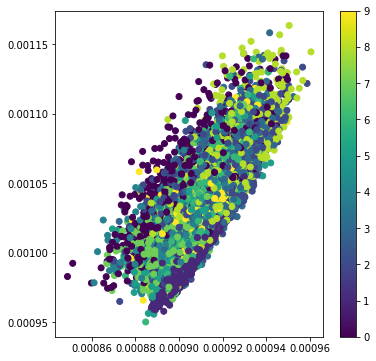

In [111]:
# Plot of the digit classes in the latent space
X_test_latent = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(X_test_latent[:, 0], X_test_latent[:, 1], c=y_test)
plt.colorbar()
plt.show()

Build decoder

In [112]:
# build decoder
decoder_input = Input(shape=(z_dim,))
_y = VAEDecoder(decoder_input) if vae_type == 'VAE' else CVAEDecoder(decoder_input)
# _z_decoded = z_decoder1(decoder_input)
# _z_decoded = z_decoder2(_z_decoded)
# _y = y_decoder(_z_decoded)
generator = Model(decoder_input, _y)
generator.summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
sequential_12 (Sequential)   (None, 784)               1461264   
Total params: 1,461,264
Trainable params: 1,461,264
Non-trainable params: 0
_________________________________________________________________


Display a 2D manifold of the digits

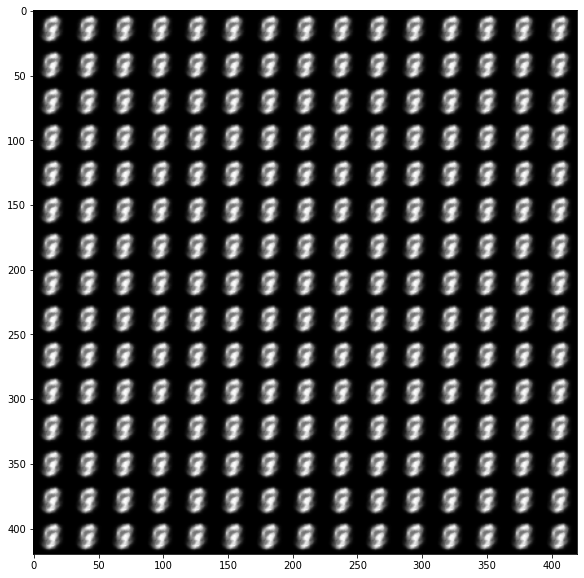

In [113]:
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [66]:
'''
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

  plot_latent_images(model, 20)
  '''

'\ndef generate_and_save_images(model, epoch, test_sample):\n    mean, logvar = model.encode(test_sample)\n    z = model.reparameterize(mean, logvar)\n    predictions = model.sample(z)\n    fig = plt.figure(figsize=(4, 4))\n\n    for i in range(predictions.shape[0]):\n        plt.subplot(4, 4, i + 1)\n        plt.imshow(predictions[i, :, :, 0], cmap=\'gray\')\n        plt.axis(\'off\')\n\n    # tight_layout minimizes the overlap between 2 sub-plots\n    plt.savefig(\'image_at_epoch_{:04d}.png\'.format(epoch))\n    plt.show()\n\ndef plot_latent_images(model, n, digit_size=28):\n  """Plots n x n digit images decoded from the latent space."""\n\n  norm = tfp.distributions.Normal(0, 1)\n  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))\n  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))\n  image_width = digit_size*n\n  image_height = image_width\n  image = np.zeros((image_height, image_width))\n\n  for i, yi in enumerate(grid_x):\n    for j, xi in enumerate(grid_y):\n      z = np.arra

### **TF: Convolutional Variational Autoencoder Original** ([Source](https://www.tensorflow.org/tutorials/generative/cvae))

Use *tf.data* to batch and shuffle the data

In [ ]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                        .shuffle(train_size)
                        .batch(batch_size)
                 )
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                               .shuffle(test_size)
                               .batch(batch_size)
                )

Define the encoder and decoder networks with *keras.Sequential*

In [ ]:
class CVAE(keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = keras.Sequential(
        [
            keras.layers.InputLayer(input_shape=(28, 28, 1)),
            keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            keras.layers.Flatten(),
            # No activation
            keras.layers.Dense(latent_dim + latent_dim),
        ]
    )
    self.decoder = keras.Sequential(
        [
            keras.layers.InputLayer(input_shape=(latent_dim,)),
            keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            keras.layers.Reshape(target_shape=(7, 7, 32)),
            keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

Define the loss function and the optimizer

In [ ]:
optimizer = keras.optimizers.Adam(1e-4)

In [ ]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

In [ ]:
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [ ]:
@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """

    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Training

In [ ]:
epochs = 100
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

In [ ]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim]
    )

model = CVAE(latent_dim)
# model.compile(optimizer='adam')
# model.summary()

In [ ]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

In [ ]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
            .format(epoch, elbo, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample)

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

In [ ]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
        last = frame
        else:
        continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info >= (6, 2, 0, ''):
    display.Image(filename=anim_file)

In [ ]:
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(anim_file)

In [ ]:
def plot_latent_images(model, n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
        z = np.array([[xi, yi]])
        x_decoded = model.sample(z)
        digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
        image[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

In [ ]:
plot_latent_images(model, 20)